In [1]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from copy import deepcopy
import random
from sklearn.metrics import accuracy_score, f1_score
from mnist import MNIST
from sklearn.model_selection import train_test_split
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dimod
from collections import defaultdict
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
#DEFINE CONSTANTS
N_EXAMPLES = 1000
N_DIMENSIONS = 100
N_CLASSIFIERS=10
LABEL_SPLIT_RATIO = 0.80

In [7]:
#Random dataset of 1000 samples
def create_dataset(label_split=0.50, n_examples=1000, n_dimensions=100):
    X = np.random.rand(n_examples, n_dimensions)
    y = np.random.rand(n_examples)
    y[np.where(y < label_split)] = -1.0
    y[np.where(y > label_split)] = 1.0
    #mndata = MNIST('/Users/pbanavara/Downloads/')
    #mndata.gz = True
    #X, y = mndata.load_training()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = create_dataset(label_split=LABEL_SPLIT_RATIO, n_examples=N_EXAMPLES,
                                                 n_dimensions=N_DIMENSIONS)

In [6]:
classifiers = [DecisionTreeClassifier(random_state=np.random.randint(10,20)) for i in range(N_CLASSIFIERS)]
cls = [clf.fit(X_train, y_train) for clf in classifiers]

In [7]:
"""
y_hat = [c.predict(X_test) for c in cls]
accuracies = [accuracy_score(y_h, np.array(y_test)) for y_h in y_hat]
f1_scores = [f1_score(y_h, np.array(y_test)) for y_h in y_hat]
"""


'\ny_hat = [c.predict(X_test) for c in cls]\naccuracies = [accuracy_score(y_h, np.array(y_test)) for y_h in y_hat]\nf1_scores = [f1_score(y_h, np.array(y_test)) for y_h in y_hat]\n'

In [8]:
print("Accuracies of Ind classifiers {}".format(accuracies))
print("F1 Scores of Ind classifiers {}".format(f1_scores))

NameError: name 'accuracies' is not defined

In [2]:
def dwave_fit(X, y, classifiers, lmd=0.2):
    print("Shape of X in Dwave fit {}".format(X.shape))
    #This is as is because in case you call this method repeatedly, a new EmbeddingCompsite has to be created
    dwave_sampler = DWaveSampler(token='CDL8-46f51e186f26242322cbc1aec03e41905112cf78', endpoint='https://cloud.dwavesys.com/sapi')
    emb_sampler = EmbeddingComposite(dwave_sampler)
    DW_PARAMS = {'num_reads': 1000,
                     'auto_scale': True,
                     'num_spin_reversal_transforms': 10,
                     'postprocess': 'sampling',
                     }
    
    n_est = len(classifiers)
    h = []
    n_data = len(X)
    for clf in classifiers:
        h.append(clf.predict(X))
    #print("Predictions on Test :::: {}".format(h))
    h = np.array(h)
    # scale hij to [-1/N, 1/N]
    h = 1. * h / len(classifiers)

    ## Create QUBO
    qii = n_data * 1. / (len(classifiers) ** 2) + lmd - 2 * np.dot(h, y)
    qij = np.dot(h, h.T)
    Q = dict()
    Q.update(dict(((k, k), v) for (k, v) in enumerate(qii)))
    for i in range(n_est):
        for j in range(i + 1, n_est):
            Q[(i, j)] = qij[i, j]

    # step 3: optimize QUBO
    res = emb_sampler.sample_qubo(Q, **DW_PARAMS)
    #res = dimod.ExactSolver().sample_qubo(Q)
    #print("Results from the sampler {}".format(list(res.data(['sample', 'energy']))))
    samples = np.array([[samp[k] for k in range(n_est)] for samp in res])

    # take the optimal solution as estimator weights
    # self.estimator_weights = np.mean(samples, axis=0)
    return samples

In [ ]:

dwave_responses = dwave_fit(X_train, y_train, cls)

In [10]:
def dwave_predict(X_test, y_test, dwave_responses, cls):
    n_data = len(X_test)
    print("X_test shape in predict function {}".format(X_test.shape))
    pred_all = np.array([h.predict(X_test) for h in cls])
    temp1 = np.dot(dwave_responses[0], pred_all)
    T1 = np.sum(temp1, axis=0) / (n_data * len(cls) * 1.)
    y = np.sign(temp1 - T1)
    acc = accuracy_score(y, y_test)
    f1 = f1_score(y, y_test)
    return acc, f1

In [ ]:
acc, f1 = dwave_predict(X_test, y_test, dwave_responses=dwave_responses)
print("Accuracy and F1 Score of the QBoost Ensemble {} {}".format(acc, f1))

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
def fit_other_ensembles(X_train, X_test, y_train, y_test, classifier):
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    acc = accuracy_score(pred, y_test) 
    f1 = f1_score(pred, y_test)
    return acc, f1

In [ ]:
r_clf = RandomForestClassifier(n_estimators=10, max_features=int(math.sqrt(dimensions)))
acc, f1 = fit_other_ensembles(X_)
ada_clf1 = AdaBoostClassifier(n_estimators=10)
ada_y_pred = ada_clf1.predict(X_train, X_test, y_train, y_test, ada_clf1, 25)
print("Accuracy and F1 Score of AdaBoost {} {}".format())

In [12]:
#Create multiple splits for graphing the comparisons
def run_classifiers(split_size_list):
    datasets = [create_dataset(label_split=s, n_examples=1000, n_dimensions=100) for s in split_size_list]

    #Accuracies and F1_scores for DWave Ensemble, RandomForest and AdaBoost
    dwave_accs = []
    dwave_f1s = []
    ada_accs = []
    ada_f1s = []
    r_accs = []
    r_f1s = []
    scores = defaultdict()
    for X_train, X_test, y_train, y_test in datasets:
        classifiers = [DecisionTreeClassifier(random_state=np.random.randint(10,20)) for i in range(N_CLASSIFIERS)]
        cls = [clf.fit(X_train, y_train) for clf in classifiers]
        dwave_responses = dwave_fit(X_train, y_train, cls)
        d_acc, d_f1 = dwave_predict(X_test, y_test, dwave_responses=dwave_responses)
        dwave_accs.append(d_acc)
        dwave_f1s.append(d_f1)
        r_clf = RandomForestClassifier(n_estimators=N_CLASSIFIERS, max_features=int(math.sqrt(N_DIMENSIONS)))
        r_acc, r_f1 = fit_other_ensembles(X_train, X_test, y_train, y_test, r_clf)
        r_accs.append(r_acc)
        r_f1s.append(r_f1)
        ada_clf = AdaBoostClassifier(n_estimators=N_CLASSIFIERS)
        a_acc, a_f1 = fit_other_ensembles(X_train, X_test, y_train, y_test, ada_clf)
        ada_accs.append(a_acc)
        ada_f1s.append(a_f1)
    scores['QBOOST_ACCS'] = dwave_accs
    scores['QBOOST_F1S'] = dwave_f1s
    scores['RF_ACCS'] = r_accs
    scores['RF_F1S'] = r_f1s
    scores['ADA_ACCS'] = ada_accs
    scores['ADA_F1S'] = ada_f1s
    return scores

In [13]:
split_sizes = [i/100 for i in range(50, 100, 5)]
scores = run_classifiers(split_size_list=split_sizes)

/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [34]:
scores['QBOOST_F1S']
split_sizes

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

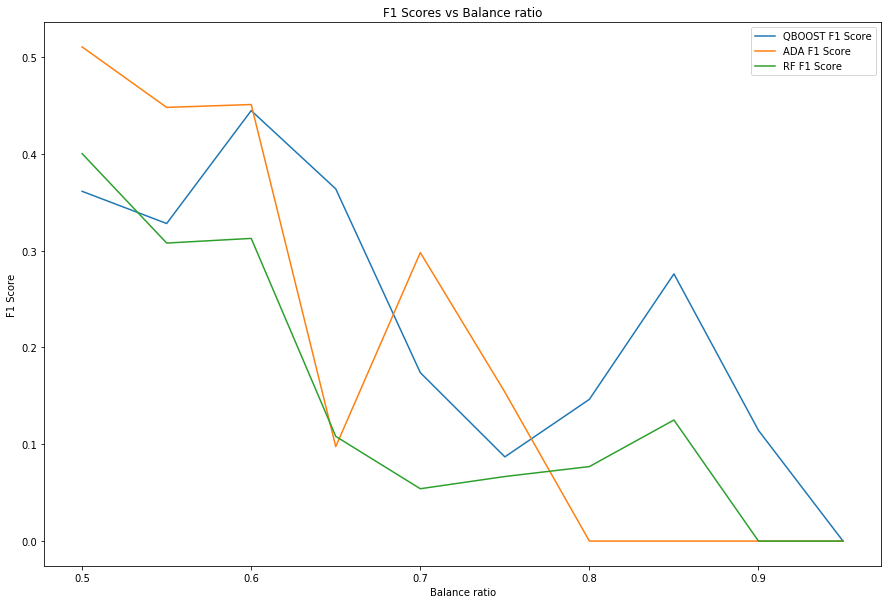

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(split_sizes, scores['QBOOST_F1S'], label='QBOOST F1 Score')
plt.plot(split_sizes, scores['ADA_F1S'], label='ADA F1 Score')
plt.plot(split_sizes, scores['RF_F1S'], label='RF F1 Score')
plt.xlabel('Balance ratio')
plt.ylabel('F1 Score')
plt.title("F1 Scores vs Balance ratio")
plt.legend()

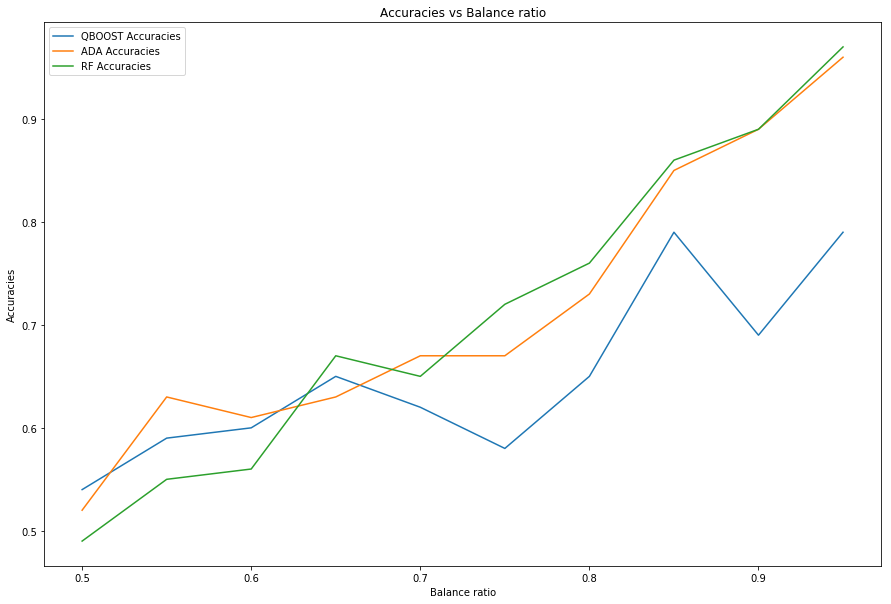

In [38]:
#Plotting Accuracies
plt.figure(figsize=(15, 10))
plt.plot(split_sizes, scores['QBOOST_ACCS'], label='QBOOST Accuracies')
plt.plot(split_sizes, scores['ADA_ACCS'], label='ADA Accuracies')
plt.plot(split_sizes, scores['RF_ACCS'], label='RF Accuracies')
plt.xlabel('Balance ratio')
plt.ylabel('Accuracies')
plt.title("Accuracies vs Balance ratio")
plt.legend()

In [11]:
#Get the scores for different dimensions
def run_classifiers_dimensions(dimensions):
    datasets = [create_dataset(label_split=.85, n_examples=10000, n_dimensions=d) for d in dimensions]

    #Accuracies and F1_scores for DWave Ensemble, RandomForest and AdaBoost
    dwave_accs = []
    dwave_f1s = []
    ada_accs = []
    ada_f1s = []
    r_accs = []
    r_f1s = []
    scores = defaultdict()
    for (X_train, X_test, y_train, y_test), d in zip(datasets, dimensions):
        print(X_train.shape, X_test.shape)
        classifiers = [DecisionTreeClassifier(random_state=np.random.randint(10,20)) for i in range(N_CLASSIFIERS)]
        cls = [clf.fit(X_train, y_train) for clf in classifiers]
        dwave_responses = dwave_fit(X_train, y_train, cls)
        d_acc, d_f1 = dwave_predict(X_test, y_test, dwave_responses=dwave_responses, cls=cls)
        dwave_accs.append(d_acc)
        dwave_f1s.append(d_f1)
        r_clf = RandomForestClassifier(n_estimators=N_CLASSIFIERS, max_features=int(math.sqrt(d)))
        r_acc, r_f1 = fit_other_ensembles(X_train, X_test, y_train, y_test, r_clf)
        r_accs.append(r_acc)
        r_f1s.append(r_f1)
        ada_clf = AdaBoostClassifier(n_estimators=N_CLASSIFIERS)
        a_acc, a_f1 = fit_other_ensembles(X_train, X_test, y_train, y_test, ada_clf)
        ada_accs.append(a_acc)
        ada_f1s.append(a_f1)
    scores['QBOOST_ACCS'] = dwave_accs
    scores['QBOOST_F1S'] = dwave_f1s
    scores['RF_ACCS'] = r_accs
    scores['RF_F1S'] = r_f1s
    scores['ADA_ACCS'] = ada_accs
    scores['ADA_F1S'] = ada_f1s
    return scores

In [13]:
dimensions = [d for d in range(25, 1000, 100)]
N_CLASSIFIERS=10
dim_scores = run_classifiers_dimensions(dimensions=dimensions)

(9000, 25) (1000, 25)
Shape of X in Dwave fit (9000, 25)
X_test shape in predict function (1000, 25)
(9000, 125) (1000, 125)
Shape of X in Dwave fit (9000, 125)
X_test shape in predict function (1000, 125)


/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(9000, 225) (1000, 225)
Shape of X in Dwave fit (9000, 225)
X_test shape in predict function (1000, 225)
(9000, 325) (1000, 325)
Shape of X in Dwave fit (9000, 325)
X_test shape in predict function (1000, 325)


/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(9000, 425) (1000, 425)
Shape of X in Dwave fit (9000, 425)
X_test shape in predict function (1000, 425)
(9000, 525) (1000, 525)
Shape of X in Dwave fit (9000, 525)
X_test shape in predict function (1000, 525)


/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(9000, 625) (1000, 625)
Shape of X in Dwave fit (9000, 625)
X_test shape in predict function (1000, 625)


/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(9000, 725) (1000, 725)
Shape of X in Dwave fit (9000, 725)
X_test shape in predict function (1000, 725)


/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


(9000, 825) (1000, 825)
Shape of X in Dwave fit (9000, 825)
X_test shape in predict function (1000, 825)
(9000, 925) (1000, 925)
Shape of X in Dwave fit (9000, 925)
X_test shape in predict function (1000, 925)


/Users/pbanavara/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


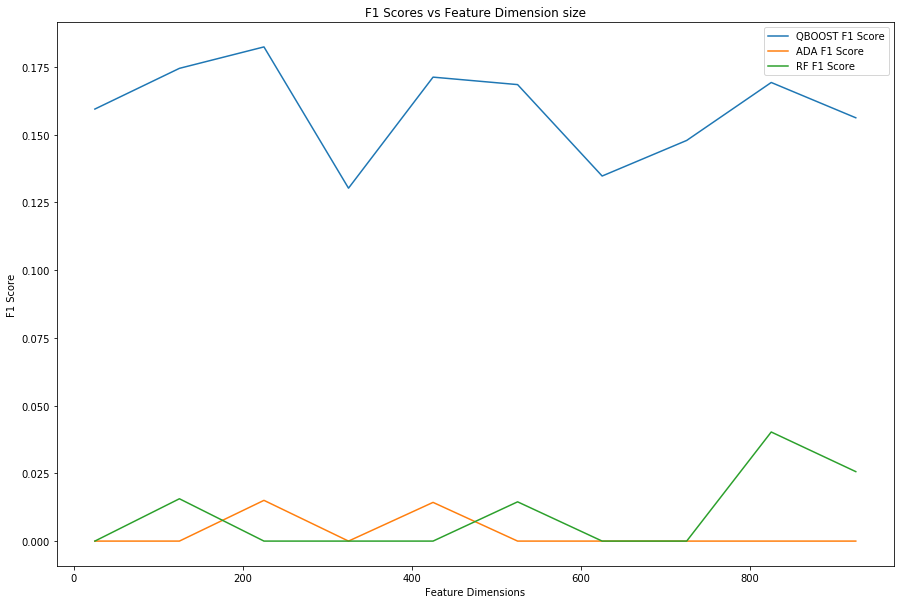

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(dimensions, dim_scores['QBOOST_F1S'], label='QBOOST F1 Score')
plt.plot(dimensions, dim_scores['ADA_F1S'], label='ADA F1 Score')
plt.plot(dimensions, dim_scores['RF_F1S'], label='RF F1 Score')
plt.xlabel('Feature Dimensions')
plt.ylabel('F1 Score')
plt.title("F1 Scores vs Feature Dimension size")
plt.legend()